# Input-output properties cells

In [1]:
import h5py
import json
import numpy as np
import os
from matplotlib import pyplot as plt

folder = os.listdir('cell_data/')
#print(folders)
cellnumber=1
print(folder[cellnumber])

rootFolder = '/home/fernando/Downloads/S1_BBP-master/S1detailed/cell_data/'+folder[cellnumber]
outFolder = '/home/fernando/Downloads/S1_BBP-master/S1detailed/cell_data/'+folder[cellnumber]
dataNetpyneFile = rootFolder+'/S1detailed.json'

print('Loading Netpyne data from %s'%dataNetpyneFile)

# Options
runPlot = 1
compareTraces = 1


L1_DAC_bNAC219_1
Loading Netpyne data from /home/fernando/Downloads/S1_BBP-master/S1detailed/cell_data/L1_DAC_bNAC219_1/S1detailed.json


File content:  -0.038940 0.0990468 0.1073007 0.1155546
	1 
	1 
	1 

Creating network of 3 cell populations on 1 hosts...
  Number of cells on node 0: 3 
  Done; cell creation time = 0.21 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 6 
  Done; cell stims creation time = 0.00 s.
Recording 6 traces of 2 types on node 0

Running simulation for 3000.0 ms...
  Done; run time = 72.21 s; real-time ratio: 0.04.

Gathering data...
  Done; gather time = 0.31 s.

Analyzing...
  Cells: 3
  Connections: 0 (0.00 per cell)
  Spikes: 0 (0.00 Hz)
  Simulated time: 3.0 s; 1 workers
  Run time: 72.21 s
Saving output as ./S1detailed.json  ... 
Finished saving!
  Done; saving time = 0.18 s.
Plotting recorded cell traces ... trace
  Done; plotting time = 0.81 s

Total time = 73.75 s


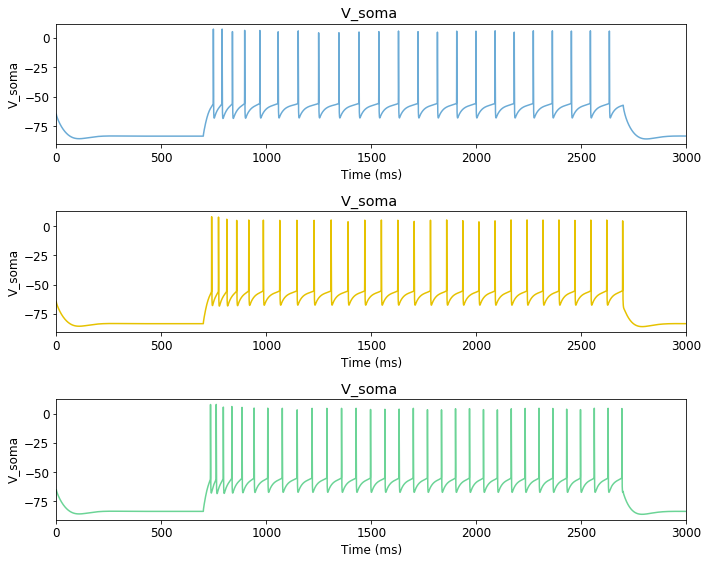

In [2]:
from netpyne import sim
from cfg import cfg
from netParams import netParams

sim.createSimulateAnalyze(netParams, cfg)

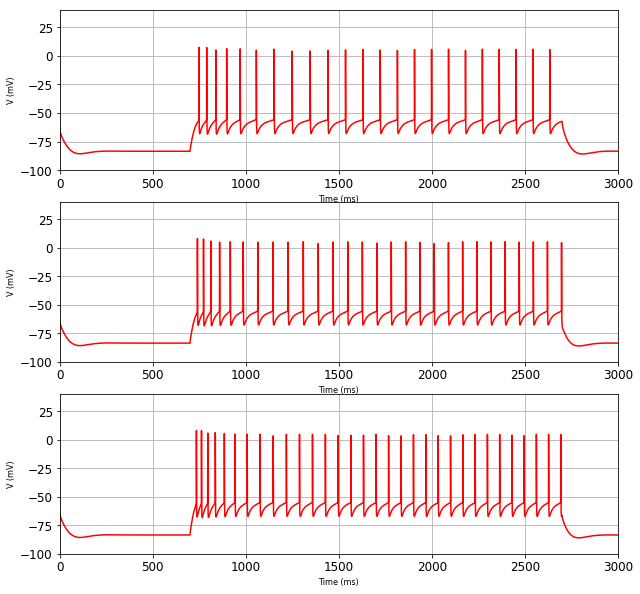

In [3]:
netpyneTraces = []
netpyneTracesList = []
for c in range(0,3):
    netpyneTraces.append(np.array(sim.simData['V_soma']['cell_'+ str(c)]))
    netpyneTracesList.append(list(sim.simData['V_soma']['cell_'+ str(c)]))
     

recordStep = sim.cfg.recordStep
timeRange = [0, sim.cfg.duration]
t = np.arange(timeRange[0], timeRange[1]+recordStep, recordStep)        
        
netpyneTracesa =np.array(netpyneTraces)
netpyneTracesa = np.transpose(netpyneTracesa)
np.savetxt(outFolder+'/netpyne_traces.dat', netpyneTracesa) 
np.savetxt(outFolder+'/netpyne_time.dat', t) 

fontsiz=8
ylim = [-100, 40]
figSize = (10,10)
fig = plt.figure(figsize=figSize)  # Open a new figure

for c in range(0,3):
    netpyneTrace = netpyneTraces[c]    
    plt.subplot(len(sim.cfg.recordCells), 1, c+1)
    plt.ylabel('V (mV)', fontsize=fontsiz)
    plt.plot(t[:len(netpyneTrace)], netpyneTrace, linewidth=1.5, color='red', label='Step %d'%(int(c))+', NetPyNE')
    plt.xlabel('Time (ms)', fontsize=fontsiz)
    plt.xlim(timeRange)
    plt.ylim(ylim)
    plt.grid(True)


In [4]:
os.chdir(rootFolder)
import neuron 

neuron.h.load_file("stdrun.hoc")
neuron.h.load_file("import3d.hoc")
print('Loading constants')
neuron.h.load_file('constants.hoc')
neuron.h.load_file("morphology.hoc")
neuron.h.load_file("biophysics.hoc")
neuron.h.load_file("template.hoc")
# Instantiate the cell from the template
add_synapses=False
print "Loading cell bNAC219_L1_DAC_ec2fc5f0de"
cell = neuron.h.bNAC219_L1_DAC_ec2fc5f0de(1 if add_synapses else 0)  

Loading constants
Setting temperature to 34.000000 C
Setting simulation time step to 0.025000 ms
Loading cell bNAC219_L1_DAC_ec2fc5f0de


In [5]:
soma = cell.soma[0]

In [6]:
stimulus = neuron.h.IClamp(0.5, sec=soma)
stimulus2 = neuron.h.IClamp(0.5, sec=soma)

In [7]:
stimulus.dur = 2000 # ms
stimulus.delay = 700  # ms     
stimulus2.dur = 3000 # ms
stimulus2.delay = 0  # ms    

In [8]:
with open('current_amps.dat') as current_file:
    current_content = current_file.read()

print 'File content: ', current_content
holding_current, step1_current, step2_current, step3_current = [float(x) for x in current_content.split()]

File content:  -0.038940 0.0990468 0.1073007 0.1155546


In [29]:
list(cell.dend[8](0.5))

[pas, k_ion, K_Tst, K_Pst, Im, Ih, na_ion, Nap_Et2, SKv3_1, NaTs2_t]

Changed dt
Soma voltage for step 1 saved to: python_recordings/soma_voltage2_step1.dat
Changed dt
Soma voltage for step 2 saved to: python_recordings/soma_voltage2_step2.dat
Changed dt
Soma voltage for step 3 saved to: python_recordings/soma_voltage2_step3.dat


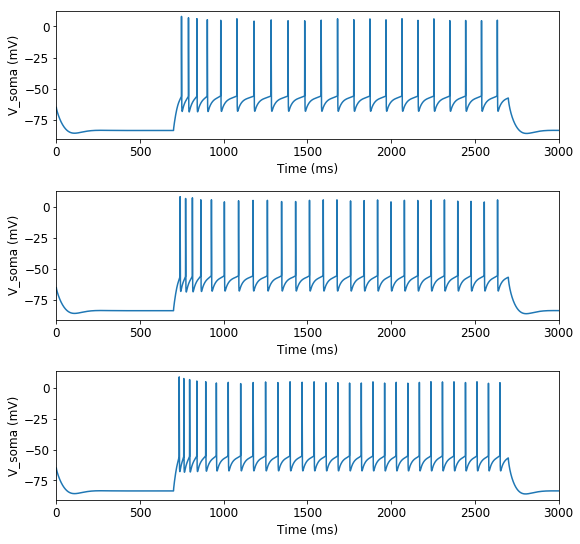

In [9]:
fig = plt.figure(figsize=(9,9))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

bmtkTraces = []
bmtkTracesList = []

stimulus2.amp = holding_current
recordings = {}

recordings['time'] = neuron.h.Vector()
recordings['soma(0.5)'] = neuron.h.Vector()

recordings['time'].record(neuron.h._ref_t, 0.1)
recordings['soma(0.5)'].record(cell.soma[0](0.5)._ref_v, 0.1)


step_number=-1
for x in current_content.split():
    step_number=step_number+1   
    
    if float(x)>0:
        stimulus.amp = float(x)
        
        neuron.h.dt = 0.05
        neuron.h.cvode_active(0)
        neuron.h.tstop = 3000 # ms
        neuron.h.run();
        
        time = np.array(recordings['time'])
        soma_voltage = np.array(recordings['soma(0.5)'])

        bmtkTraces.append(soma_voltage)
        bmtkTracesList.append(list(soma_voltage))

        recordings_dir = 'python_recordings'

        soma_voltage_filename = os.path.join(
            recordings_dir,
            'soma_voltage2_step%d.dat' % step_number)
        np.savetxt(soma_voltage_filename, zip(time, soma_voltage))

        print('Soma voltage for step %d saved to: %s'
              % (step_number, soma_voltage_filename))
            
        ax = fig.add_subplot(3, 1, step_number)
        ax.plot(time,soma_voltage)
        plt.xlabel('Time (ms)')
        plt.ylabel('V_soma (mV)')
        plt.xlim(0,3000)

fig.savefig('{s1}/{s}.png'.format(s1=rootFolder,s=folder[cellnumber]))

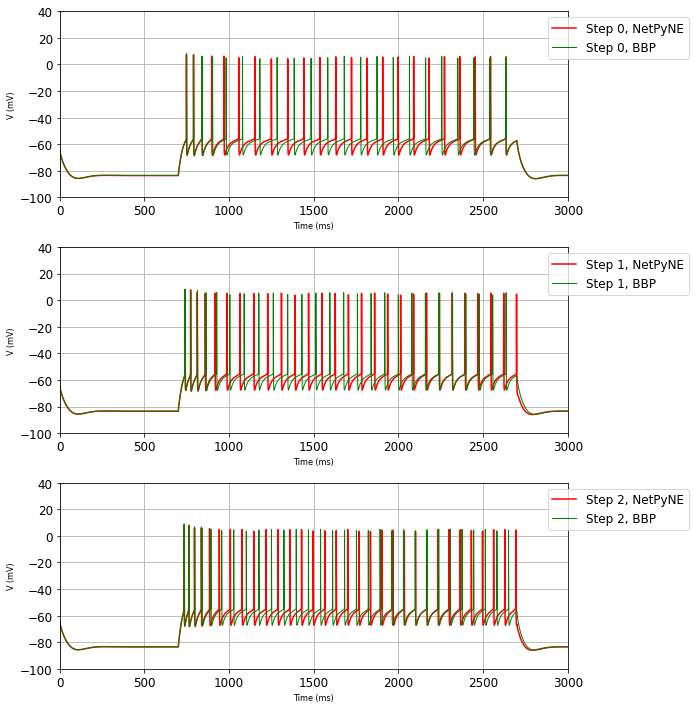

In [10]:
if compareTraces:
    # plot both traces overlayed
    fontsiz=8
    timeRange = [0, sim.cfg.duration]
    ylim = [-100, 40]
    figSize = (10,10)
    fig = plt.figure(figsize=figSize)  # Open a new figure

    for c in range(0,3):
        netpyneTrace = netpyneTraces[c]
        bmtkTrace = bmtkTraces[c]
        t = np.arange(timeRange[0], timeRange[1]+recordStep, recordStep)
        plt.subplot(len(sim.cfg.recordCells), 1, c+1)
        plt.ylabel('V (mV)', fontsize=fontsiz)
        plt.plot(t[:len(netpyneTrace)], netpyneTrace, linewidth=1.5, color='red', label='Step %d'%(int(c))+', NetPyNE')
        plt.plot(t[:len(bmtkTrace)], bmtkTrace, linewidth=1.0, color='green', label='Step %d'%(int(c))+', BBP')  # linestyle=':'
        plt.xlabel('Time (ms)', fontsize=fontsiz)
        plt.xlim(timeRange)
        plt.ylim(ylim)
        plt.grid(True)
        plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.0))
    plt.ion()
    plt.tight_layout()
    plt.savefig(outFolder+'/comparison_traces.png')
    plt.show()